In [1]:
!pip install stochastic -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 1.9 MB/s eta 0:00:00


To verify the automatic differentiability of the TensorFlow-based HurstEE layer, an experiment was conducted in which the layer was used to correct or modify the two-dimensional trajectories of individual particles. The initial trajectories were generated as fBm with an initial Hurst exponent (corresponding to the initial anomalous diffusion exponent $\alpha_0$), and as a result of the optimization process, these trajectories corresponded to a different specified anomalous diffusion exponent $\alpha_{target}$. The integration of the TA-MSD layer into the neural network architecture and the enabling of gradient propagation through the layer allowed the network to adjust trajectories based on the deviation of the estimated anomalous diffusion exponent from the target value $\alpha_{target}$ [186].In addition to the deviation of the estimated exponent $\alpha$ from $\alpha_{target}$, the Jarque–Bera test criterion, which combines skewness and kurtosis, was added to the optimization loss [187]. This proved necessary to preserve the normality of the increment distribution in the optimized trajectory.In the experiment, the network received a trajectory as input and corrected it at each optimization step, bringing it closer to the specified anomalous diffusion exponent. The differentiability of the TA-MSD layer enabled the minimization of the loss function, defined as the deviation between the estimated and target exponents. To evaluate the correctness of the model, the Whittle method was used, which confirmed that the results of the anomalous diffusion exponent estimation for the ensemble of corrected trajectories were consistent with expectations [188].During the experiment, 2000 trajectories were transformed from an initial exponent of $\alpha=0.7$ to a target of $\alpha=1.5$.

In [2]:
import autograd.numpy as np
from autograd import grad
import scipy.optimize as so
from math import gamma
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from tqdm.auto import tqdm
from stochastic.processes.noise import FractionalGaussianNoise as FGN
from scipy.stats import anderson

# =============================================================================
# Function to compute the TA-MSD exponent (analogous to forward TAMSDalpha)
# =============================================================================

import autograd.numpy as np

def nanmean(arr, axis=None):
    """
    Computes the mean value of an array, ignoring NaNs, with autograd support.
    
    Parameters:
        arr (numpy.ndarray): Input array.
        axis (int, optional): Axis along which the mean is computed. Default is None (mean over all elements).
    
    Returns:
        float or numpy.ndarray: Mean value, ignoring NaNs.
    """
    # Create a mask for NaN values
    mask = ~np.isnan(arr)
    
    # Replace NaN with 0 so they don't affect the sum
    arr_safe = np.where(mask, arr, 0)
    
    # Calculate the sum of elements, ignoring NaN
    sum_values = np.sum(arr_safe, axis=axis)
    
    # Count non-NaN elements
    count_non_nan = np.sum(mask, axis=axis)
    
    # Protection against division by zero
    count_non_nan = np.where(count_non_nan > 0, count_non_nan, 1)
    
    # Compute the mean
    mean_value = sum_values / count_non_nan
    
    return mean_value


def tamsd_alpha(inputs):
    """
    Computes the estimated anomalous exponent alpha for each example.
    
    Parameters:
        inputs (np.ndarray): array of shape (batch, timesteps, input_channels)
        
    Returns:
        np.ndarray: exponent estimates (shape: (batch,))
    """
    batch_size, timesteps, input_channels = inputs.shape
    T = float(timesteps)
    epsilon = 1e-14
    max_lag = 6

    msds = []

    for lag in range(1, max_lag + 1):
        displacements = inputs[:, lag:, :] - inputs[:, :-lag, :]
        squared_displacements = displacements ** 2
        squared_displacements_sum = np.sum(squared_displacements, axis=2)
        msd = nanmean(squared_displacements_sum, axis=1)
        msds.append(msd)

        
    msds = np.stack(msds, axis=1)       # shape: (batch, max_lag)

    
    t_lags = np.arange(1, max_lag + 1, dtype=np.float32)
    log_t_lags = np.log(t_lags + epsilon)
    


    mean_x = np.mean(log_t_lags)
    mean_x2 = np.mean(log_t_lags ** 2)

    denominator = mean_x2 - mean_x ** 2

    
    # TA-MSD alpha for each example
    log_msds = np.log(msds + epsilon)  # shape: (batch, max_lag)
    mean_y = np.mean(log_msds, axis=1)   # shape: (batch,)
    mean_xy = np.mean(log_t_lags * log_msds, axis=1)
    numerator = mean_xy - mean_x * mean_y
    alpha = numerator / denominator

        
    alpha = np.clip(alpha, 0.0001, 1.999)
    return alpha / 2  # divide by 2 to match original logic

# =============================================================================
# Whittle and TA-MSD methods (unchanged)
# =============================================================================

def whittle(data):
    """Calculation of the Hurst exponent using the Maximum Likelihood method on the periodogram"""
    nbpoints = len(data)
    nhalfm = int((nbpoints - 1) / 2)
    tmp = np.abs(np.fft.fft(data))
    gammahat = np.exp(2 * np.log(tmp[1:nhalfm + 1])) / (2 * np.pi * nbpoints)
    func = lambda Hurst: whittlefunc(Hurst, gammahat, nbpoints)
    return so.fminbound(func, 0, 1)

def whittle_t(data, pointeur, idx):
    nbpoints = len(data)
    nhalfm = int((nbpoints - 1) / 2)
    tmp = np.abs(np.fft.fft(data))
    gammahat = np.exp(2 * np.log(tmp[1:nhalfm + 1])) / (2 * np.pi * nbpoints)
    func = lambda Hurst: whittlefunc(Hurst, gammahat, nbpoints)
    pointeur[idx] = so.fminbound(func, 0, 1)

def whittle_s(data, idx):
    dataidx = data[idx, :]
    nbpoints = len(dataidx)
    nhalfm = int((nbpoints - 1) / 2)
    tmp = np.abs(np.fft.fft(dataidx))
    gammahat = np.exp(2 * np.log(tmp[1:nhalfm + 1])) / (2 * np.pi * nbpoints)
    func = lambda Hurst: whittlefunc(Hurst, gammahat, nbpoints)
    return so.fminbound(func, 0, 1)

def whittle_norm_s(data, idx):
    dataidx = data[idx, :]
    nbpoints = len(dataidx)
    datanorm = (dataidx - np.mean(dataidx)) / np.var(dataidx)
    nhalfm = int((nbpoints - 1) / 2)
    tmp = np.abs(np.fft.fft(datanorm))
    gammahat = np.exp(2 * np.log(tmp[1:nhalfm + 1])) / (2 * np.pi * nbpoints)
    func = lambda Hurst: whittlefunc(Hurst, gammahat, nbpoints)
    return so.fminbound(func, 0, 1)

def whittlefunc(hurst, gammahat, nbpoints):
    gammatheo = fspec_fgn(hurst, nbpoints)
    qml = gammahat / gammatheo
    return 2 * (2 * np.pi / nbpoints) * np.sum(qml)

def fspec_fgn(hest, nbpoints):
    hhest = - ((2 * hest) + 1)
    const = np.sin(np.pi * hest) * gamma(- hhest) / np.pi
    nhalfm = int((nbpoints - 1) / 2)
    dpl = 2 * np.pi * np.arange(1, nhalfm + 1) / nbpoints
    fspec = np.ones(nhalfm)
    for i in np.arange(0, nhalfm):
        dpfi = np.arange(0, 200)
        dpfi = 2 * np.pi * dpfi
        fgi = (np.abs(dpl[i] + dpfi)) ** hhest
        fhi = (np.abs(dpl[i] - dpfi)) ** hhest
        dpfi = fgi + fhi
        dpfi[0] = dpfi[0] / 2
        dpfi = (1 - np.cos(dpl[i])) * const * dpfi
        fspec[i] = np.sum(dpfi)
    fspec = fspec / np.exp(2 * np.sum(np.log(fspec)) / nbpoints)
    return fspec



def disp_fbm(H: float, D: float, T: int, deltaT: int = 1):
    '''Generates normalized fractional Gaussian noise (fGN).'''
    disp = [FGN(hurst=H).sample(n=T) for _ in range(2000)]
    disp = np.array(disp)
    disp *= np.sqrt(T)**(H*2)
    disp *= np.sqrt(2*D*deltaT)        
    return disp

In [3]:
import autograd.numpy as np
from autograd import grad
import scipy.optimize as so

# ==========================================
# Differentiable Normality Criteria
# ==========================================

def anderson_darling_autograd(data):
    """
    Differentiable version of the Anderson-Darling statistic.
    Lower values = more normal distribution.
    """
    data_flat = data.flatten()
    data_sorted = np.sort(data_flat)
    n = len(data_sorted)
    
    mean = np.mean(data_sorted)
    std = np.std(data_sorted) + 1e-10
    
    # Standardization
    z = (data_sorted - mean) / std
    
    # CDF approximation via tanh (smooth and differentiable)
    def norm_cdf_approx(x):
        return 0.5 * (1 + np.tanh(0.7978845608 * (x + 0.044715 * x**3)))
    
    # Compute A² statistic
    i = np.arange(1, n + 1, dtype=np.float64)
    cdf_vals = norm_cdf_approx(z)
    cdf_vals = np.clip(cdf_vals, 1e-10, 1 - 1e-10)
    
    log_cdf = np.log(cdf_vals)
    log_1_minus_cdf = np.log(1 - cdf_vals[::-1])
    
    S = np.sum((2*i - 1) * (log_cdf + log_1_minus_cdf))
    A2 = -n - S / n
    
    return A2


def calculate_jb_stat(data_flat):
    """Helper function to calculate the JB statistic"""
    n = len(data_flat)
    if n < 3: return 0.0
    
    mean = np.mean(data_flat)
    std = np.std(data_flat) + 1e-10
    standardized = (data_flat - mean) / std
    
    # Skewness
    S = np.mean(standardized**3)
    
    # Kurtosis
    K = np.mean(standardized**4)
    
    # Jarque-Bera Statistic
    JB = (n / 6) * (S**2 + (K - 3)**2 / 4)
    return JB

def normality_moment_loss(increments, axis=1):
    """
    Computes loss based on skewness and kurtosis
    for each row separately.
    """
    # Mean and standard deviation along the time axis
    mean = np.mean(increments, axis=axis, keepdims=True)
    std = np.std(increments, axis=axis, keepdims=True) + 1e-8  # epsilon for stability
    
    # Standardization (z-score)
    z = (increments - mean) / std
    
    # Moments
    skewness = np.mean(z**3, axis=axis)
    kurtosis = np.mean(z**4, axis=axis)
    
    # Loss: deviation of skewness from 0 and kurtosis from 3 (for normal distribution)
    loss = (skewness)**2 + (kurtosis - 3)**2
    return loss

def multi_scale_jarque_bera_loss(increments, axis=1):
    """
    Vectorized version of the Jarque-Bera test (simplified for loss).
    """
    n = increments.shape[axis]
    
    mean = np.mean(increments, axis=axis, keepdims=True)
    std = np.std(increments, axis=axis, keepdims=True) + 1e-8
    z = (increments - mean) / std
    
    S = np.mean(z**3, axis=axis) # Skewness
    K = np.mean(z**4, axis=axis) # Kurtosis
    
    # JB Statistic: (n/6) * (S^2 + (1/4)*(K-3)^2)
    # We don't use the strict test, just the magnitude as Loss
    jb_stat = (n / 6.0) * (S**2 + 0.25 * (K - 3)**2)
    
    return jb_stat


# ==========================================
# Functions for result analysis
# ==========================================

def analyze_normality(trajectories):
    """
    Analyzes the normality of trajectory increments.
    
    Computes Anderson, Shapiro, Skewness, and Kurtosis for each trajectory
    and returns the mean value and Std Dev of these metrics across the entire array.
    """
    from scipy.stats import anderson, shapiro, jarque_bera

    # Calculation of increments for ALL trajectories
    # trajectories has shape (Number of trajectories, 2 (x, y), Number of steps)
    increments_x = trajectories[:, 1:, 0] - trajectories[:, :-1, 0]
    increments_y = trajectories[:, 1:, 1] - trajectories[:, :-1, 1]    
    num_trajectories = trajectories.shape[0]
    
    # Dictionaries to store results for EACH trajectory
    all_results = {'whittle': [], 'TA-MSD': [], 
        'anderson_x': [], 'anderson_y': [],
        'shapiro_x_stat': [], 'shapiro_x_pval': [],
        'shapiro_y_stat': [], 'shapiro_y_pval': [],
        'skewness_x': [], 'skewness_y': [],
        'kurtosis_x': [], 'kurtosis_y': []
    }
    
    # Iteration over each trajectory
    for i in range(num_trajectories):
        inc_x = increments_x[i]
        inc_y = increments_y[i]
        
        # Check for sufficient data for Shapiro-Wilk (needs > 2)
        if len(inc_x) <= 2 or len(inc_y) <= 2:
            # Can skip or insert np.nan, here I skip to avoid distorting the mean
            continue 


        whittle_xy = whittle(inc_x) + whittle(inc_y)
        all_results['whittle'].append(whittle_xy / 2)

        # --- Anderson Test ---
        # Anderson test does not return p-value, only the statistic
        anderson_x = anderson(inc_x)
        anderson_y = anderson(inc_y)
        all_results['anderson_x'].append(anderson_x.statistic)
        all_results['anderson_y'].append(anderson_y.statistic)

        # --- Shapiro-Wilk Test ---
        shapiro_x = shapiro(inc_x)
        shapiro_y = shapiro(inc_y)
        all_results['shapiro_x_stat'].append(shapiro_x.statistic)
        all_results['shapiro_x_pval'].append(shapiro_x.pvalue)
        all_results['shapiro_y_stat'].append(shapiro_y.statistic)
        all_results['shapiro_y_pval'].append(shapiro_y.pvalue)
        
        # --- Moments: Skewness and Kurtosis ---
        # Calculation using standardization
        
        # Skewness
        std_inc_x = (inc_x - inc_x.mean()) / inc_x.std()
        std_inc_y = (inc_y - inc_y.mean()) / inc_y.std()
        
        all_results['skewness_x'].append(np.mean(std_inc_x**3))
        all_results['skewness_y'].append(np.mean(std_inc_y**3))
        
        # Kurtosis (often normalized to 3 for normal distribution)
        all_results['kurtosis_x'].append(np.mean(std_inc_x**4))
        all_results['kurtosis_y'].append(np.mean(std_inc_y**4))

    # Calculate TA-MSD (assuming function exists in context)
    H_estimated = tamsd_alpha(trajectories)
    all_results['TA-MSD'] = H_estimated.tolist()

    # --- Averaging results ---
    final_results = {}
    for key, values in all_results.items():
        if values:
            final_results[f'mean_{key}'] = np.mean(values)
            final_results[f'std_{key}'] = np.std(values)
        else:
            final_results[f'mean_{key}'] = np.nan
            final_results[f'std_{key}'] = np.nan
            
    return final_results

def print_normality_report(initial_trajs, optimized_trajs):
    """
    Prints a report on normality before and after optimization.
    Uses mean value and Std Dev across all trajectories.
    """
    print("\n" + "=" * 80)
    print("NORMALITY DISTRIBUTION REPORT (Averaged over all trajectories)")
    print("=" * 80)
    
    # --- BEFORE OPTIMIZATION ---
    print("\nBEFORE OPTIMIZATION:")
    print("-" * 80)
    initial_results = analyze_normality(initial_trajs)
    
    # Group results for better display
    keys = list(initial_results.keys())
    # Split into pairs (mean_*, std_*)
    for i in range(0, len(keys), 2):
        mean_key = keys[i]
        std_key = keys[i+1]
        
        # Display metric name without "mean_"
        metric_name = mean_key[5:]
        
        mean_val = initial_results[mean_key]
        std_val = initial_results[std_key]
        
        print(f"| {metric_name:25s} | Mean: {mean_val:.4f} | Std Dev: {std_val:.4f} |")

    # --- AFTER OPTIMIZATION ---
    print("\nAFTER OPTIMIZATION:")
    print("-" * 80)
    optimized_results = analyze_normality(optimized_trajs)
    
    keys = list(optimized_results.keys())
    for i in range(0, len(keys), 2):
        mean_key = keys[i]
        std_key = keys[i+1]
        metric_name = mean_key[5:]
        mean_val = optimized_results[mean_key]
        std_val = optimized_results[std_key]
        
        print(f"| {metric_name:25s} | Mean: {mean_val:.4f} | Std Dev: {std_val:.4f} |")
    
    print("\nINTERPRETATION:")
    print("-" * 80)
    print("• **Skewness:** Mean should be **close to 0**. Std Dev shows spread across trajectories.")
    print("• **Kurtosis:** Mean should be **close to 3** (for normal distribution). Std Dev shows spread.")
    print("• **Anderson (statistic):** **Lower mean value** indicates higher normality. Lower Std Dev = more stable result.")
    print("• **Shapiro p-value:** Mean **> 0.05** indicates normal distribution. Higher Std Dev means the percentage of trajectories passing the test may vary.")

# ==========================================
# Modified Optimization Function
# ==========================================

def spectral_loss_autograd(increments, H_target):
    """
    Computes loss based on the slope of the Power Spectral Density (PSD).
    Differentiable version for autograd.
    """
    n = increments.shape[1]
    
    # 1. FFT Calculation (autograd supports fft)
    # fft returns complex numbers, take the magnitude
    fft_vals = np.fft.fft(increments, axis=1)
    psd = np.abs(fft_vals)**2 / n
    
    # Take only the first half of the spectrum (positive frequencies), discarding 0th frequency
    cutoff = n // 2
    psd_half = psd[:, 1:cutoff]
    
    # Frequencies (logically they go as 1, 2, ... cutoff)
    freqs = np.arange(1, cutoff, dtype=np.float64)
    
    # 2. Logarithmization
    log_freqs = np.log(freqs)
    log_psd = np.log(psd_half + 1e-10) # epsilon
    
    # 3. Theoretical slope for fGn: beta = 1 - 2H
    # Line equation: log_psd = beta * log_freq + C
    # We want to minimize the deviation of the slope from the theoretical one.
    
    beta_target = 1.0 - 2.0 * H_target
    
    # For each batch, compute empirical slope (via covariance/variance or just line error)
    # Simplest: force log_psd to lie on a line with slope beta_target.
    
    # Center variables for stability
    mean_log_freq = np.mean(log_freqs)
    centered_log_freq = log_freqs - mean_log_freq
    
    # Theoretical shape of spectrum (up to a Y-shift constant)
    # theoretical_shape = beta_target * centered_log_freq
    
    # Empirical slope for each row
    mean_log_psd = np.mean(log_psd, axis=1, keepdims=True)
    centered_log_psd = log_psd - mean_log_psd
    
    # beta_est = sum(x*y) / sum(x^2)
    numerator = np.sum(centered_log_freq * centered_log_psd, axis=1)
    denominator = np.sum(centered_log_freq ** 2)
    
    beta_estimated = numerator / denominator
    
    # Loss = squared difference of slopes
    slope_loss = np.mean((beta_estimated - beta_target) ** 2)
    
    return slope_loss

# ----------------------------------------------------------------
# UPDATED OPTIMIZATION FUNCTION
# ----------------------------------------------------------------

def optimize_time_series_with_normality_spectral(
    time_series, 
    H_target, 
    D_target, 
    max_iter=1000,
    normality_weight=1.0,  # Normality weight
    spectral_weight=1.0,   # NEW WEIGHT: Spectral correctness weight
    normality_method='jarque_bera'
):
    
    if normality_method == 'jarque_bera':
        normality_fn = multi_scale_jarque_bera_loss
    else:
        normality_fn = normality_moment_loss
    
    ts = time_series.astype(np.float64)
    original_shape = ts.shape
    x0 = ts.flatten()
    
    def loss_flat(x):
        ts_reshaped = x.reshape(original_shape)
        
        # --- 1. Loss from TA-MSD (Local structure) ---
        alpha_x = tamsd_alpha(ts_reshaped[:,:,:1])
        alpha_y = tamsd_alpha(ts_reshaped[:,:,1:])
        hurst_loss = np.mean((alpha_x - H_target) ** 2) + np.mean((alpha_y - H_target) ** 2)
        
        # --- 2. Normality loss ---
        increments_x = ts_reshaped[:, 1:, 0] - ts_reshaped[:, :-1, 0]
        increments_y = ts_reshaped[:, 1:, 1] - ts_reshaped[:, :-1, 1]
        
        norm_loss_x = np.mean(normality_fn(increments_x, axis=1))
        norm_loss_y = np.mean(normality_fn(increments_y, axis=1))
        normality_loss_total = norm_loss_x + norm_loss_y
        
        # --- 3. NEW: Spectral loss (Global structure) ---
        # This is a "substitute" for Whittle that works with autograd
        spec_loss_x = spectral_loss_autograd(increments_x, H_target)
        spec_loss_y = spectral_loss_autograd(increments_y, H_target)
        spectral_loss_total = spec_loss_x + spec_loss_y

        # Combination
        total_loss = (
            hurst_loss + 
            (normality_weight * normality_loss_total) +
            (spectral_weight * spectral_loss_total)
        )
        
        return total_loss
    
    grad_loss = grad(loss_flat)
    
    print(f"Start Optim: Normality={normality_weight}, Spectral={spectral_weight}")
    result = so.minimize(
        loss_flat, x0, jac=grad_loss, method='L-BFGS-B',
        options={'maxiter': max_iter, 'gtol': 1e-8, 'disp': True}
    )
    
    return result.x.reshape(original_shape)

# ==========================================
# Usage example
# ==========================================

if __name__ == "__main__":
    # Assuming you have:
    # - cum_initial_series: initial trajectories
    # - tamsd_alpha: function to compute exponent
    
    print("=" * 60)
    print("Optimization with normality control")
    print("=" * 60)
    
    # Parameters
    D_target = 10.0
    # Set time series parameters
    T = 60
    hurst = 0.35
    H_target = 0.75 
    D = 10
    
    # Generate initial time series using fractional Brownian motion (fBM)
    initial_series = disp_fbm(hurst, D, T - 1)
    # Compute cumulative sum and add zero at the beginning
    cum_initial_series = np.cumsum(initial_series, axis=-1)
    cum_initial_series = np.concatenate([np.zeros((2000, 1)), cum_initial_series], axis=-1)  # shape: (batch, T)
    
    # Reshape cumulative series to form (batch, D, T)
    cum_initial_series = cum_initial_series.reshape(-1, 2, T).transpose(0, 2, 1)

    # Optimization with different methods
    # methods = ['moments', 'jarque_bera', 'anderson']
    methods = ['jarque_bera']
    for method in methods:
        print(f"\nMethod: {method}")
        print("-" * 40)
        
        # Example call (replace cum_initial_series with your data)
        cum_optimized_series = optimize_time_series_with_normality_spectral(
            time_series=cum_initial_series,
            H_target=H_target,
            D_target=D_target,
            max_iter=1000,
            normality_weight=0.001,
            spectral_weight=0.333,  # Important to give sufficient weight to spectrum
            normality_method='jarque_bera'
        )
        
        print(f"Settings: normality weight = 1.0")
        # Exponent estimation for initial time series (input has shape (batch, T, D))
        H_estimated_initial = tamsd_alpha(cum_initial_series)
        print("Estimated Hurst exponents before optimization with TA-MSD: mean=", 
              H_estimated_initial.mean(), "  std=", H_estimated_initial.std())
        
        
        
        H_estimated_optimized = tamsd_alpha(cum_optimized_series)
        print("Estimated Hurst exponents after optimization with TA-MSD: mean=", 
              H_estimated_optimized.mean(), "  std=", H_estimated_optimized.std())
        
        print_normality_report(cum_initial_series, cum_optimized_series)

Optimization with normality control

Method: jarque_bera
----------------------------------------
Start Optim: Normality=0.001, Spectral=0.333
Settings: normality weight = 1.0
Estimated Hurst exponents before optimization with TA-MSD: mean= 0.34224515272950035   std= 0.06618658275861694
Estimated Hurst exponents after optimization with TA-MSD: mean= 0.7461522727650781   std= 0.04597039870860779

NORMALITY DISTRIBUTION REPORT (Averaged over all trajectories)

BEFORE OPTIMIZATION:
--------------------------------------------------------------------------------
| whittle                   | Mean: 0.3447 | Std Dev: 0.0654 |
| TA-MSD                    | Mean: 0.3422 | Std Dev: 0.0662 |
| anderson_x                | Mean: 0.3811 | Std Dev: 0.1761 |
| anderson_y                | Mean: 0.3701 | Std Dev: 0.1815 |
| shapiro_x_stat            | Mean: 0.9790 | Std Dev: 0.0097 |
| shapiro_x_pval            | Mean: 0.4857 | Std Dev: 0.2839 |
| shapiro_y_stat            | Mean: 0.9799 | Std Dev: 0.0

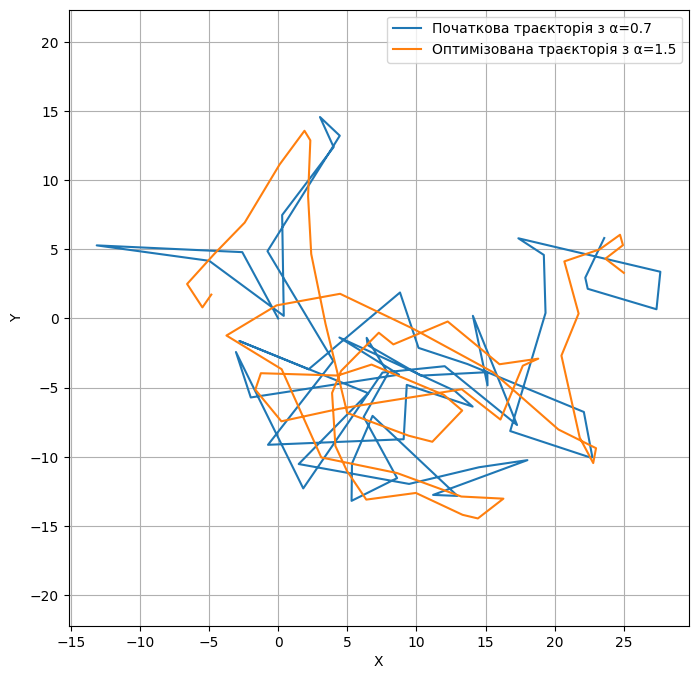

In [4]:
t_number = 3

plt.figure(figsize=(8, 8))
plt.plot(cum_initial_series[t_number,:, 0], cum_initial_series[t_number,:, 1], label='Початкова траєкторія з α=0.7')
plt.plot(cum_optimized_series[t_number,:, 0], cum_optimized_series[t_number,:, 1], label='Оптимізована траєкторія з α=1.5')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()



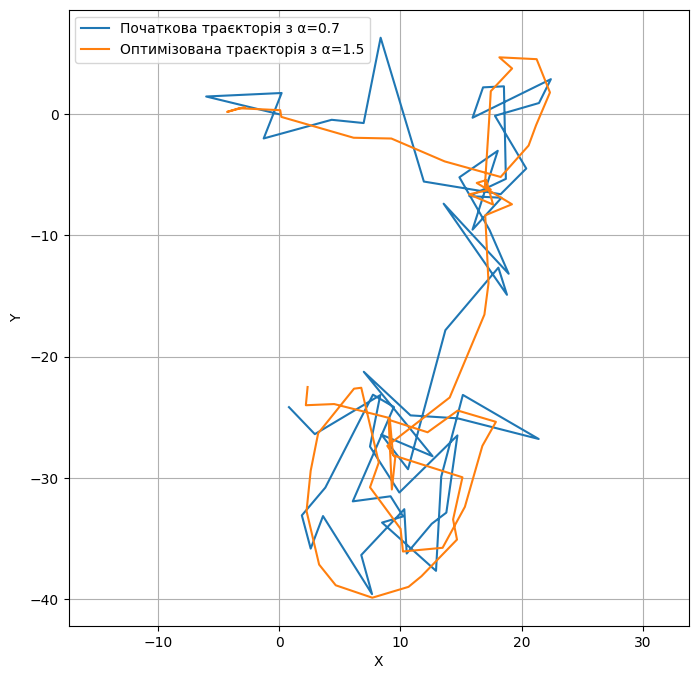

In [5]:
t_number = 4

plt.figure(figsize=(8, 8))
plt.plot(cum_initial_series[t_number,:, 0], cum_initial_series[t_number,:, 1], label='Початкова траєкторія з α=0.7')
plt.plot(cum_optimized_series[t_number,:, 0], cum_optimized_series[t_number,:, 1], label='Оптимізована траєкторія з α=1.5')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()


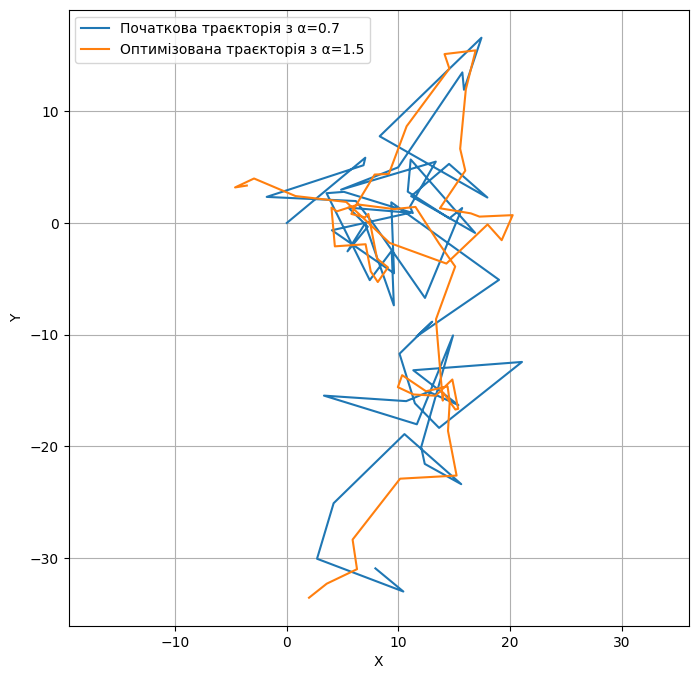

In [6]:
t_number = 5

plt.figure(figsize=(8, 8))
plt.plot(cum_initial_series[t_number,:, 0], cum_initial_series[t_number,:, 1], label='Початкова траєкторія з α=0.7')
plt.plot(cum_optimized_series[t_number,:, 0], cum_optimized_series[t_number,:, 1], label='Оптимізована траєкторія з α=1.5')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()


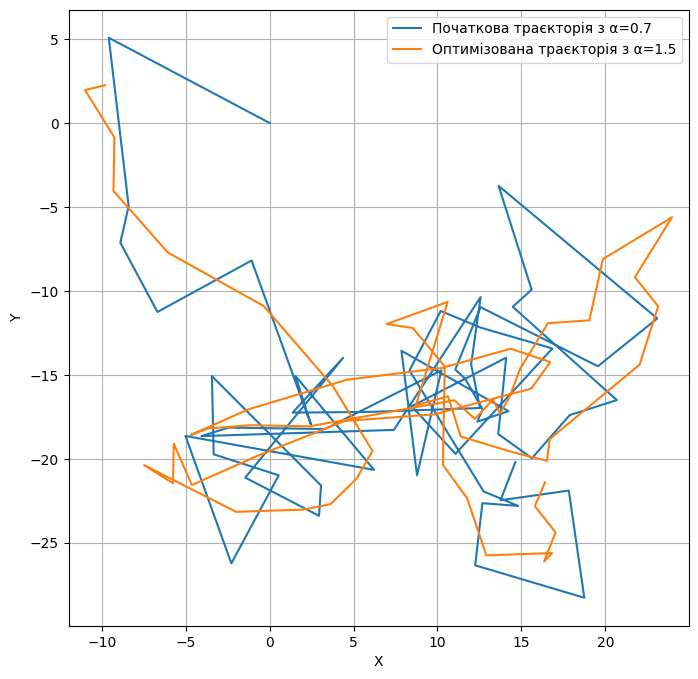

In [7]:
t_number = 6

plt.figure(figsize=(8, 8))
plt.plot(cum_initial_series[t_number,:, 0], cum_initial_series[t_number,:, 1], label='Початкова траєкторія з α=0.7')
plt.plot(cum_optimized_series[t_number,:, 0], cum_optimized_series[t_number,:, 1], label='Оптимізована траєкторія з α=1.5')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()
